# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [1]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import math
import string

spark = SparkSession.builder.appName("SparkIntro").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [2]:
df = spark.read.option('header', True).option('inferSchema', True).option('delimiter', ',')\
    .option('multiline', True).option("escape", "\"").csv('data/listings.csv')

### Describe the data
List the features (schema) and sizes of the datasets.

In [3]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [4]:
df.count()

1330480

In [5]:
df.show(2)

+------+--------------------+--------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------+--------------------+--------------+-------+--------------------+---------+----------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+-------------+----------------------+----------------------------+---------+----------------+-------+---------+-----------------+------------+-------+--------+---------+-----------------+-------------+---------------+------------+---------+--------+----+--------+--------------------+-----

In [6]:
df.select('amenities').show(3)

+--------------------+
|           amenities|
+--------------------+
|{TV,"Cable TV",Wi...|
|{TV,"Cable TV",In...|
|{TV,Wifi,Kitchen,...|
+--------------------+
only showing top 3 rows



**This dataset contains a lot of information, i.e. there are many variables. Some variables are lists as the one shown above, and therefore it is necessary to read the file with the "multiline"-option enabled.**

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

**First, I want to reduce the data. There is a lot of variables, and not all are going to be used in the analysis. I have considered two ways of cleaning the data. The first would be to get rid of the columns with a lot of text, since these will take up a lot of space and make writing/reading to/from disk slow. However, in this particular setting it is possible to get an overwiev of which parameters are needed by considering all the questions in the project, and therefore I will drop everything but the columns I need.**

**Furthermore, I want to cast the variables as the correct types, and the price should be without the $-character.**

In [7]:
#    .filter(f.col('id').isNotNull())\
#    .filter(f.col('city').isNotNull())\
#    .filter(f.col('neighbourhood').isNotNull())\
#    .filter(f.col('property_type').isNotNull())\
#    .filter(f.col('price').isNotNull())\
#    .filter(f.col('review_scores_rating').isNotNull())\

**I want to filter out null values at a later stage, since not all columns are used for all queries later on.**

In [8]:
df.select('id','city','neighbourhood','property_type', 'price', 'review_scores_rating')\
    .withColumn('id_int', f.col('id').cast('int')).drop('id')\
    .withColumn('id', f.col('id_int')).drop('id_int')\
    .withColumn('price_flt', f.regexp_replace('price', '\$', '').cast('float')).drop('price')\
    .withColumn('price', f.col('price_flt')).drop('price_flt')\
    .withColumn('review_scores_rating_flt', f.col('review_scores_rating').cast('float')).drop('review_scores_rating')\
    .withColumn('review_scores_rating', f.col('review_scores_rating_flt')).drop('review_scores_rating_flt')\
    .write.mode('overwrite')\
    .option('header', True)\
    .option('multiline', True)\
    .option("escape", "\"")\
    .csv('data/df_prep.csv', emptyValue='')

In [9]:
df_prep = spark.read\
    .option('header', True)\
    .option('inferSchema', True)\
    .option('delimiter', ',')\
    .option('multiline', True)\
    .option("escape", "\"")\
    .csv('data/df_prep.csv')

**I have skipped all columns that conained multilines, but I have kept the multiline option, so that if I want to include those columns at a later time, I won't forget to swich it on.**

**The datafile is now only 60MB, in stead of 5 GB.**

In [10]:
df_prep.printSchema()

root
 |-- city: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)



In [11]:
df_prep.count()

1330480

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

**First, I want to get an overwiev of the data. I therefore compute a dataframe with al the cities and how many listings and neighbourhoods they contain.**

In [12]:
listings_neighbourhoods = df_prep.filter(f.col('city').isNotNull())\
    .filter(f.col('id').isNotNull())\
    .filter(f.col('neighbourhood').isNotNull())\
    .groupBy('city')\
    .agg(f.countDistinct('id').alias('listings'),f.countDistinct('neighbourhood').alias('neighbourhoods'))\
    .orderBy(f.col('neighbourhoods'), ascending = False)

In [13]:
listings_neighbourhoods.show()

+--------------+--------+--------------+
|          city|listings|neighbourhoods|
+--------------+--------+--------------+
|Greater London|   46523|           149|
|        London|   33684|           148|
|       Toronto|   21765|           140|
|     San Diego|   12315|           109|
|    Washington|    9063|           108|
|      New York|   21535|           100|
|   Los Angeles|   27800|            97|
|        Berlin|   24282|            93|
|Rio de Janeiro|   18552|            93|
|      Portland|    4487|            90|
|       Chicago|    8822|            88|
|   Minneapolis|    2928|            88|
|        Sydney|    1151|            82|
|       Oakland|    3123|            81|
|       Seattle|    9020|            80|
|        Austin|   10438|            79|
|        Denver|    4533|            77|
|     Barcelona|   19894|            68|
|        Dublin|    4018|            66|
|        Madrid|   20660|            66|
+--------------+--------+--------------+
only showing top

**I choose to continue working with the city of Berlin, since it is a city with a lot of listings and a lot of neighbourhoods. Furthermore, the name does not seem to be ambiguous as for instance London is. I therfore filter out Berlin, and I want to save to disk at this stage, bacause I am going to reduce the dataset by a significant amount.**

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [14]:
df_prep.filter(f.col('city') == 'Berlin')\
    .write.mode('overwrite')\
    .option('header', True)\
    .option('multiline', True)\
    .option("escape", "\"")\
    .csv('data/Berlin.csv', emptyValue='')

In [15]:
df_berlin = spark.read\
    .option('header', True)\
    .option('inferSchema', True)\
    .option('delimiter', ',')\
    .option('multiline', True)\
    .option("escape", "\"")\
    .csv('data/Berlin.csv')

**I now want to get an overwiev of the new reduced dataset:**

In [16]:
df_berlin.count()

24283

In [17]:
df_berlin.select('id', 'property_type','neighbourhood').show()

+-----+-------------+---------------+
|   id|property_type|  neighbourhood|
+-----+-------------+---------------+
| 1944|    Apartment|        Wedding|
| 2015|   Guesthouse|          Mitte|
| 3176|    Apartment|Prenzlauer Berg|
| 3309|    Apartment|     Schöneberg|
| 6883|         Loft| Friedrichshain|
| 7071|    Apartment|Prenzlauer Berg|
| 9991|    Apartment|Prenzlauer Berg|
|14325|    Apartment|Prenzlauer Berg|
|16401|    Apartment| Friedrichshain|
|16644|    Apartment|      Kreuzberg|
|17904|    Apartment|       Neukölln|
|20858|         Loft|Prenzlauer Berg|
|21869|    Apartment|      Kreuzberg|
|22415|    Apartment|      Kreuzberg|
|22677|    Apartment|          Mitte|
|23834|  Condominium|      Kreuzberg|
|24569|    Apartment|Prenzlauer Berg|
|25653|    Apartment|Prenzlauer Berg|
|26543|    Apartment|Prenzlauer Berg|
|28156|    Apartment|Prenzlauer Berg|
+-----+-------------+---------------+
only showing top 20 rows



In [18]:
df_berlin.filter(f.col('neighbourhood').isNotNull())\
    .filter(f.col('neighbourhood').isNotNull())\
    .filter(f.col('property_type').isNotNull())\
    .groupBy('neighbourhood')\
    .agg(f.countDistinct('property_type').alias('property_types'))\
    .orderBy('neighbourhood')\
    .show()

+--------------------+--------------+
|       neighbourhood|property_types|
+--------------------+--------------+
|           Adlershof|             6|
|Alt-Hohenschönhausen|             7|
|         Alt-Treptow|             6|
|        Altglienicke|             4|
|      Baumschulenweg|             5|
|            Biesdorf|             6|
|         Blankenburg|             4|
|           Bohnsdorf|             3|
|               Britz|             7|
|                Buch|             1|
|              Buckow|             4|
|      Charlottenburg|            14|
| Charlottenburg-Nord|             3|
|              Dahlem|             4|
|          Falkenberg|             3|
|  Falkenhagener Feld|             2|
|           Fennpfuhl|             3|
|Französisch Buchholz|             6|
|           Friedenau|             9|
|     Friedrichsfelde|             5|
+--------------------+--------------+
only showing top 20 rows



**Now I can compute the number of listings per property type in each neigbourhood. I do not want to show all the data, since there are a lot of neighbourhoods and a lot of property types. In stead, I have chosen just to show the first four neighbourhoods. I could make a bar plot, but I think it will become to messy, so I just show the dataframe. It is seen, unsurprisingly, that in these neighbourhoods, apartments and houses are most frequent.**

In [19]:
listings_property_neighbourhood = df_berlin.groupBy('neighbourhood','property_type').agg(f.count('id').alias('listings')).orderBy('neighbourhood')
listings_property_neighbourhood.show(24)

+--------------------+------------------+--------+
|       neighbourhood|     property_type|listings|
+--------------------+------------------+--------+
|                null|         Apartment|       1|
|           Adlershof|         Apartment|      25|
|           Adlershof|             House|       1|
|           Adlershof|         Townhouse|       1|
|           Adlershof|        Guesthouse|       1|
|           Adlershof|          Bungalow|       1|
|           Adlershof|Serviced apartment|       1|
|Alt-Hohenschönhausen|        Guesthouse|       1|
|Alt-Hohenschönhausen|       Condominium|       3|
|Alt-Hohenschönhausen|              Loft|       1|
|Alt-Hohenschönhausen|         Townhouse|       3|
|Alt-Hohenschönhausen|             House|       9|
|Alt-Hohenschönhausen|Serviced apartment|       1|
|Alt-Hohenschönhausen|         Apartment|      30|
|         Alt-Treptow|              Loft|       5|
|         Alt-Treptow|       Condominium|       3|
|         Alt-Treptow|         

## Prices
Compute the minimum, maximum and average listing price in your city. 

**The average price is computed by using an aggregate function:**

In [20]:
df_berlin.filter(f.col('price').isNotNull())\
    .agg(f.avg('price').alias('avg'))\
    .withColumn('average_price', f.round('avg', 2))\
    .drop('avg')\
    .select('average_price')\
    .show()

+-------------+
|average_price|
+-------------+
|        63.52|
+-------------+



**It turns out, that some prices are 0.00. This might be an error, and it might be possible to determine by looking at some of the descriptions of the partivcular listings.:**

In [21]:
df_berlin.select('price','id').filter(f.col('price') == 0).show()

+-----+--------+
|price|      id|
+-----+--------+
|  0.0|18612697|
|  0.0|20382969|
|  0.0|20448073|
|  0.0|20671210|
|  0.0|21154484|
|  0.0|28175257|
+-----+--------+



**One price is 1 dollar. This might also be an error. The second cheapest listing is then $8, which is probably more realistic.**

In [22]:
df_berlin.filter(f.col('price') > 1.0)\
    .agg(f.min('price').alias('minimum_price'))\
    .show()

+-------------+
|minimum_price|
+-------------+
|          8.0|
+-------------+



In [23]:
df_berlin.agg(f.max('price').alias('maximum_price')).show()

+-------------+
|maximum_price|
+-------------+
|        999.0|
+-------------+



Compute and visualize the distribution of listing prices in your city.

**I want to take the data into Python in order to make a histogram. The data retrieved with the collect() command will come out as row elemens. They can be converted to a list with a lambda function as showed in the commented code below. It can also be done with a pandas dataframe, which make the code mode nice.**

In [24]:
#rows = df_berlin.filter(f.col('price').isNotNull()).select('price').collect()
#prices_list = list(map(lambda r: [r['price_flt'], r['frequency']], rows))
#berlin_prices = pd.DataFrame(prices_list)

In [25]:
berlin_prices = pd.DataFrame(df_berlin.filter(f.col('price').isNotNull()).select('price').collect())

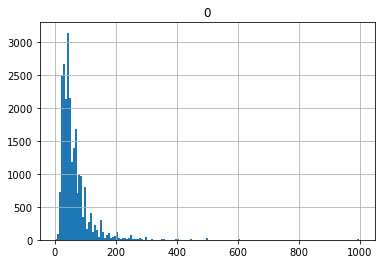

In [26]:
berlin_prices.hist(bins = int(math.sqrt(len(berlin_prices))))
plt.show()

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

**This can be done with a window function. There is a lot of neighbourhoods, so I have chosen just to show a few of them.**

In [27]:
berlin_values = df_berlin.filter(f.col('review_scores_rating').isNotNull())\
    .filter(f.col('price').isNotNull())\
    .withColumn('value', f.col('review_scores_rating')/f.col('price'))

In [28]:
w = Window.partitionBy('neighbourhood').orderBy(f.asc('value'))

In [29]:
berlin_values_ranked = berlin_values.withColumn('value_rank', f.rank().over(w))

In [30]:
berlin_values_ranked.select('neighbourhood','id','value_rank','value')\
    .filter(f.col('value_rank') <= 3)\
    .orderBy('neighbourhood','value_rank')\
    .show()

+--------------------+--------+----------+-------------------+
|       neighbourhood|      id|value_rank|              value|
+--------------------+--------+----------+-------------------+
|                null| 7219506|         1| 1.2894736842105263|
|           Adlershof|24439697|         1| 0.7194244604316546|
|           Adlershof|21353684|         2| 1.3157894736842106|
|           Adlershof|37707025|         3| 1.6666666666666667|
|Alt-Hohenschönhausen|25170640|         1|0.22248803827751196|
|Alt-Hohenschönhausen|38109259|         2|0.36363636363636365|
|Alt-Hohenschönhausen|13060403|         3| 0.4092827004219409|
|         Alt-Treptow| 7845886|         1|               0.64|
|         Alt-Treptow|33657379|         2| 0.6666666666666666|
|         Alt-Treptow| 5502882|         2| 0.6666666666666666|
|        Altglienicke|23464738|         1| 0.9545454545454546|
|        Altglienicke|  354033|         2| 1.2972972972972974|
|        Altglienicke|16137777|         3|             

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

**First, I will get an overview of the reviews dataset and prepare it for a join.**

In [31]:
rev = spark.read\
    .option('header', True)\
    .option('inferSchema', True)\
    .option('delimiter', ',')\
    .option('multiline', True)\
    .option("escape", "\"")\
    .csv('data/reviews.csv')

In [32]:
rev.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [33]:
df_berlin.printSchema()

root
 |-- city: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)



In [34]:
rev_prep = rev.withColumn('listing_id_int', f.col('listing_id').cast('int'))\
    .withColumn('review_id', f.col('id').cast('int'))\
    .drop('reviewer_id', 'reviewer_name', 'listing_id', 'id')\
    .withColumn('listing_id', f.col('listing_id_int'))\
    .drop('listing_id_int', 'id_int')

In [35]:
berlin_join_rev = rev_prep.join(f.broadcast(df_berlin), (f.col('listing_id') == f.col('id')), 'inner')

In [36]:
berlin_join_rev.count()

497829

**Since a join is expensive, I save the joined dataframe.**

In [37]:
berlin_join_rev.write.mode('overwrite')\
    .option('header', True)\
    .option('multiline', True)\
    .option("escape", "\"")\
    .csv('data/Berlin_join_rev.csv', emptyValue='')

In [38]:
df_berlin_listings_reviews = spark.read\
    .option('header', True)\
    .option('inferSchema', True)\
    .option('delimiter', ',')\
    .option('multiline', True)\
    .option("escape", "\"")\
    .csv('data/Berlin_join_rev.csv')

**I now calculate the number of reviews on a given day and imort it to a pandas dataframe. I also store it as a Spark dataframe, since I am going to use that later on.**

In [39]:
total_revs_df = df_berlin_listings_reviews.orderBy('date')\
    .groupBy('date')\
    .agg(f.count('review_id').alias('total_revs'))

total_revs = pd.DataFrame(total_revs_df.collect())

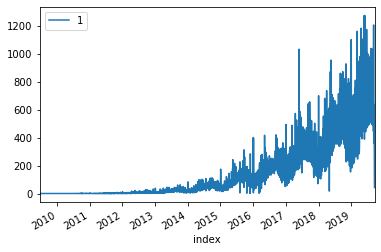

In [40]:
total_revs.reset_index(inplace=True)
total_revs['index'] = pd.to_datetime(total_revs[0])
total_revs.set_index('index',inplace=True)

total_revs[[1]].plot(kind='line')
plt.show()

**A rapid increase in 'popularity' (actually number of reviews) is seen. This is most likely NOT showing the popularity of the city, but rather the increase in popularity of Airbnb... One could calculate the total reviews from the whole world and compare Berlin to that in order to get a relative number, which would be a better measure of the city popularity. I think that is out of the scope of this part of the assignment, but I will do that for the individual neighbourhoods as shown below.**

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

**I choose Two large neighbourhoods in the former west (Schöneberg, Wedding) and two large neighbourhoods in the former East (Friedrichshain, Prenzlauer Berg).**

**I now prepare four Pandas dataframes, so I can visualize the popularity of the neighbourhoods over time.**

In [41]:
schoneberg_revs = pd.DataFrame(df_berlin_listings_reviews.filter(f.col('neighbourhood') == 'Schöneberg').orderBy('date').groupBy('date').agg(f.count('review_id').alias('total_revs')).collect())
wedding_revs = pd.DataFrame(df_berlin_listings_reviews.filter(f.col('neighbourhood') == 'Wedding').orderBy('date').groupBy('date').agg(f.count('review_id').alias('total_revs')).collect())
friedrichshain_revs = pd.DataFrame(df_berlin_listings_reviews.filter(f.col('neighbourhood') == 'Friedrichshain').orderBy('date').groupBy('date').agg(f.count('review_id').alias('total_revs')).collect())
prenzlauerberg_revs = pd.DataFrame(df_berlin_listings_reviews.filter(f.col('neighbourhood') == 'Prenzlauer Berg').orderBy('date').groupBy('date').agg(f.count('review_id').alias('total_revs')).collect())

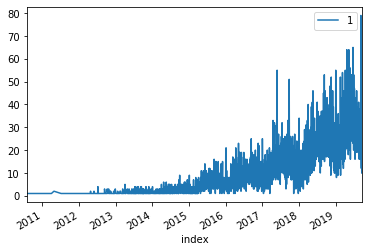

In [42]:
schoneberg_revs.reset_index(inplace=True)
schoneberg_revs['index'] = pd.to_datetime(schoneberg_revs[0])
schoneberg_revs.set_index('index',inplace=True)

schoneberg_revs[[1]].plot(kind='line')
plt.show()

**It is seen that the Schöneberg reviews follow the same trend as the total reviews. I therefore want to compare the 'popularity' of the neighbourhoods with the 'popularity' of the city, so I can get rid of the trend of increasing use of Airbnb.**

**I therefore want to join the dataframe with reviews from each of the neighbourhoods with the dataframe with the reviews for the whole city, so that I can compare the neighbourhoods with the city total.**

**First, I prepare a dataframe for each neighbourhood for a join.:**

In [43]:
schoneberg_revs_df = df_berlin_listings_reviews.filter(f.col('neighbourhood') == 'Schöneberg').withColumn('date_s', f.col('date')).drop('date').orderBy('date_s').groupBy('date_s').agg(f.count('review_id').alias('total_revs_s'))
wedding_revs_df = df_berlin_listings_reviews.filter(f.col('neighbourhood') == 'Wedding').withColumn('date_w', f.col('date')).drop('date').orderBy('date_w').groupBy('date_w').agg(f.count('review_id').alias('total_revs_w'))
friedrichshain_revs_df = df_berlin_listings_reviews.filter(f.col('neighbourhood') == 'Friedrichshain').withColumn('date_f', f.col('date')).drop('date').orderBy('date_f').groupBy('date_f').agg(f.count('review_id').alias('total_revs_f'))
prenzlauerberg_revs_df = df_berlin_listings_reviews.filter(f.col('neighbourhood') == 'Prenzlauer Berg').withColumn('date_p', f.col('date')).drop('date').orderBy('date_p').groupBy('date_p').agg(f.count('review_id').alias('total_revs_p'))

**Second, I join each of the dataframes with the dataframe for the whole city and import it to Python by using Pandas:**

In [44]:
schoneberg_join = pd.DataFrame(schoneberg_revs_df.join(f.broadcast(total_revs_df), (f.col('date_s') == f.col('date')), 'inner').drop('date').withColumn('index_s', f.col('total_revs_s')/f.col('total_revs')).collect())
wedding_join = pd.DataFrame(wedding_revs_df.join(f.broadcast(total_revs_df), (f.col('date_w') == f.col('date')), 'inner').drop('date').withColumn('index_w', f.col('total_revs_w')/f.col('total_revs')).collect())
friedrichshain_join = pd.DataFrame(friedrichshain_revs_df.join(f.broadcast(total_revs_df), (f.col('date_f') == f.col('date')), 'inner').drop('date').withColumn('index_f', f.col('total_revs_f')/f.col('total_revs')).collect())
prenzlauerberg_join = pd.DataFrame(prenzlauerberg_revs_df.join(f.broadcast(total_revs_df), (f.col('date_p') == f.col('date')), 'inner').drop('date').withColumn('index_p', f.col('total_revs_p')/f.col('total_revs')).collect())

**Now I can finally show the number of reviews in the four neighburhoods relative to the number of reviews in the whole city.:**

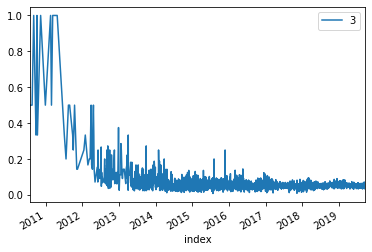

In [45]:
schoneberg_join.reset_index(inplace=True)
schoneberg_join['index'] = pd.to_datetime(schoneberg_join[0])
schoneberg_join.set_index('index',inplace=True)

schoneberg_join[[3]].plot(kind='line')
plt.show()

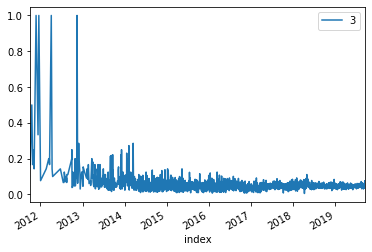

In [46]:
wedding_join.reset_index(inplace=True)
wedding_join['index'] = pd.to_datetime(wedding_join[0])
wedding_join.set_index('index',inplace=True)

wedding_join[[3]].plot(kind='line')
plt.show()

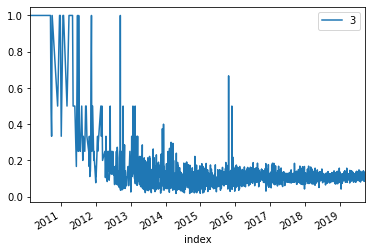

In [47]:
friedrichshain_join.reset_index(inplace=True)
friedrichshain_join['index'] = pd.to_datetime(friedrichshain_join[0])
friedrichshain_join.set_index('index',inplace=True)

friedrichshain_join[[3]].plot(kind='line')
plt.show()

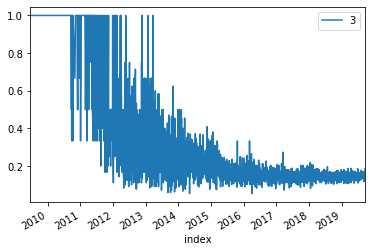

In [48]:
prenzlauerberg_join.reset_index(inplace=True)
prenzlauerberg_join['index'] = pd.to_datetime(prenzlauerberg_join[0])
prenzlauerberg_join.set_index('index',inplace=True)

prenzlauerberg_join[[3]].plot(kind='line')
plt.show()

**In the beginning of the period, the index oscillates violently and sometimes becomes one for each neighbourhoods. This is because there is very few reviews in the beginning of the period, so sometimes the one review in one of the neighbourhoods is the only review given in the whole city, and therefore the relative number becomes one.**

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

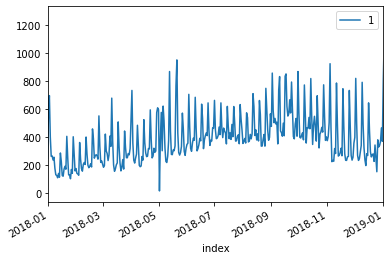

In [49]:
seasonplot = total_revs[[1]].plot(kind='line')
seasonplot.set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-01-01'))
plt.show()

**This shows some rapid oscillations and a peak in the middle of the autumn. This is not nescessarily because there are more activity in the autumn, but might be beacause there is a time gap from when people books a room until they rate it. So maybe the peak activity is actually in the summer, as we would expect.**

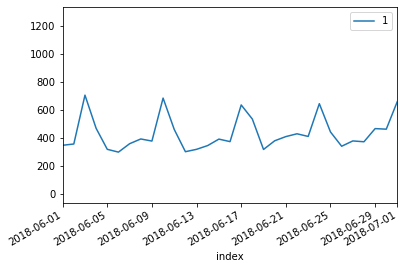

In [50]:
seasonplot = total_revs[[1]].plot(kind='line')
seasonplot.set_xlim(pd.Timestamp('2018-06-01'), pd.Timestamp('2018-07-01'))
plt.show()

**The plot above shows the number of reviews in june 2018. 4-5 peaks are seen, and a close look at the dates reveals that the peaks are indeed on saturdays and sundays. I would expect them to be at fridays and saturdays, because people are more likely to book a room in the weekend. But again, this shows the time of the reviews, rather than the time of the bookings. So the plot actually shows that people write many more (about twice as many) reviews in the weekends, which makes good sense.**

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

In [51]:
df_berlin_listings_reviews.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- comments: string (nullable = true)
 |-- review_id: integer (nullable = true)
 |-- listing_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- review_scores_rating: double (nullable = true)



In [100]:
sample = df_berlin_listings_reviews.filter((f.col('listing_id') >= 20000000) & (f.col('listing_id') <= 20010000))\
    .drop('date','review_id','listing_id','city','neighbourhood','property_type','id','price')

In [101]:
sample.count()

62

In [54]:
sample_.write.mode('overwrite')\
    .option('header', True)\
    .option('multiline', True)\
    .option("escape", "\"")\
    .csv('data/sample.csv', emptyValue='')

In [55]:
sample = spark.read\
    .option('header', True)\
    .option('inferSchema', True)\
    .option('delimiter', ',')\
    .option('multiline', True)\
    .option("escape", "\"")\
    .csv('data/sample.csv')

In [104]:
sample.count()

62

In [57]:
df_berlin_listings_reviews.count()

497829

In [58]:
sample.printSchema()

root
 |-- comments: string (nullable = true)
 |-- review_scores_rating: double (nullable = true)



**I want to make a dictionary of the words I see. First I need to remove special characters. The weighting function is merely a shift in the rating, such that ratings below 50% count negative. In that way, some of the neutral words like e.g. "is" should in principle be somewhat cancelled out (unless positive reviews for example are much longer than negative). I will not deal with that for now, though.**

In [67]:
def positivity(rating,comment):
    words = {}
    for i in comment.translate(str.maketrans('', '', string.punctuation)).split():
        words[i] = round(words.get(i,(rating-50)/100) + (rating-50)/100 ,2)
    return words

positivity_udf = f.udf(positivity)


In [102]:
positivity_count_sample = sample.withColumn('positivity_scores', positivity_udf('review_scores_rating','comments'))\
    .select('positivity_scores').collect()

In [103]:
positivity_count_sample

[Row(positivity_scores='{bed=0.98, A=0.98, very=1.47, a=0.98, big=0.98, Big=0.98, recommend=0.98, is=0.98, experience=0.98, good=0.98, room=0.98, nice=1.47, would=0.98, and=1.47, flat=0.98, host=0.98, helpful=0.98, discreet=0.98, Henry=0.98, Very=0.98}'),
 Row(positivity_scores='{déco=0.98, quelques=0.98, notre=0.98, facile=0.98, couch=0.98, distinctes=0.98, beautiful=0.98, des=0.98, trip=0.98, Lappartement=0.98, permettait=0.98, les=1.47, because=0.98, you=0.98, dune=1.47, want=0.98, nous=2.45, an=0.98, each=0.98, 1=0.98, 2=0.98, gigantesque=0.98, 3=1.47, at=0.98, 4=1.47, flexible=0.98, offering=0.98, nécessité=0.98, least=0.98, I=0.98, agréable=0.98, recommend=0.98, warmly=0.98, sleep=0.98, The=1.96, min=0.98, Notre=0.98, porte=1.47, kitchen=0.98, so=0.98, But=1.47, a=3.43, ce=1.96, necessary=0.98, rares=0.98, recommande=0.98, one=0.98, makes=0.98, où=0.98, Lemplacement=0.98, stay=1.96, the=2.94, s=0.98, definitely=0.98, croisé=0.98, sympa=1.47, Ring=1.47, closed=0.98, to=1.47, but=0

**The output is a long string with words and positivity scores. I have not yet figured out how to concatenate all the rows in pyspark or to put them into a separate dataframe, so that the positivity scores could be summed using groupBy or countDistinct**

**In Python, however, it would not be difficult to transform the above into a dataframe, but I think that the problem should be solved within Spark.**

**Another problem is that the method above only works for a very small sample.**

**As sad as it can be, I have not had the time to make this work.**

In [62]:
#test = list(map(lambda r: r['positivity_scores'], testefest))